# **Acetaminophen Attenuates Perception of Auditory Stimuli**
# ***PERCEIVED EMOTION DATA***

# **Goal 1: Long Form Analysis**
The initial Qualtrics data was pre-processed in a separate R script. For this part of the analysis, we will build on those dataframes and perform the following tasks:
1. Examination of Missing Data
2. Checking for Duplicates
3. Adding High-Level Summary Features
4. Looking at Mean Differences between Drug and Placebo
    * Overall means
    * Stimulus type (music, natural sounds, and speech)
    * Emotion type (positive, negative, neutral)
    * Arousal and valence levels
    
**We will do this separately for *induced* emotion data and *perceived* emotion data**

In [36]:
# basic coding/ML tools
import numpy as np, pandas as pd, os, sys, scipy, xlrd, urllib, pandas_profiling, itertools, re, warnings
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.stats import ttest_ind
from fancyimpute import KNN

# ML tools
import sklearn, statsmodels.api as sm, statsmodels.formula.api as smf, cvxopt, pingouin as pg
from statsmodels.stats.anova import AnovaRM
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report, multilabel_confusion_matrix
from imblearn.over_sampling import SMOTE

# visualization tools
import matplotlib.pyplot as plt, qgrid, seaborn as sns, IPython.display
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import Image, HTML
from plotnine import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# View tab (Taken from Martin: https://stackoverflow.com/users/2575273/martin)
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))
files = os.listdir(os.curdir)

# set directory
os.chdir("/Users/home/Desktop/Research/Tylenol/Analysis")
print(os.getcwd())

# only get warnings once
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None)

# # toggle on/off code!
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


/Users/home/Desktop/Research/Tylenol/Analysis


### Read in Data
Read in the data.

In [2]:
perceivedLong = pd.read_csv('Fixed Perceived.csv')
print("original perceivedLong shape:", perceivedLong.shape)
    # original perceivedLong shape: (9842, 33)
    
View(perceivedLong.head().T)

original perceivedLong shape: (9842, 33)


### Missing Data
We will delete observations with no ID or without a drug/placebo indication. We cannot use these observations for analysis.

In [3]:
# examine
null = perceivedLong[perceivedLong.isnull().any(axis=1)]
print("null shape:", null.shape) 

pd.DataFrame(perceivedLong.isnull().sum())

# delete 'Other' column
perceivedLong = perceivedLong.drop(['Other'], axis=1)

# drop rows where there's no ID or drug/placebo information
perceivedLong = perceivedLong.dropna(subset=['FixedID', 'DrugCode', 'DrugPlacebo'], how='any')

print("new perceivedLong shape:", perceivedLong.shape)
View(pd.DataFrame(perceivedLong.isnull().mean()*100))

null shape: (9287, 33)
new perceivedLong shape: (9250, 32)


### Check for Duplicates
Duplicates would indicate an error with the participant ID number fed into the surveys on Qualtrics. These would lead to biased data, so we get rid of them. 

In [4]:
# Check number of perceived stimuli
print("Number of Perceived Stimuli: ", len(perceivedLong['Stimulus'].unique()), "\n")

# Check max ID number
maxid = int(perceivedLong['FixedID'].max())
    
# make dataframe checking the number of perceived/induced stimuli per person
participants = pd.DataFrame()
participants['Potential'] = pd.Series(range(1, maxid+1))
participants = participants.set_index('Potential')
participants['Perceived'] = perceivedLong[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])

# where are the errors?
pError = list(participants[participants['Perceived'] > len(perceivedLong['Stimulus'].unique())].index)
print("perceived errors in stimuli: ", pError, "\n")

View(perceivedLong[perceivedLong['FixedID'].isin(pError)])

# delete all IDs who are in error
    # it must be due to some kind of coding mistake or mistake with Qualtrics entries
drop = perceivedLong[perceivedLong['FixedID'].isin(pError)].index
perceivedLong.drop(drop, inplace=True)

# check
print("fixed perceivedLong shape:", perceivedLong.shape, "\n")

participants['PerceivedFixed'] = perceivedLong[['FixedID','DrugCode']].groupby(['FixedID']).agg(['count'])
pErrorCheck = list(participants[participants['PerceivedFixed'] > len(perceivedLong['Stimulus'].unique())].index)
print("perceived errors in stimuli: ", pErrorCheck)
View(participants)

Number of Perceived Stimuli:  37 

perceived errors in stimuli:  [55, 91, 92, 117, 275] 

fixed perceivedLong shape: (8880, 32) 

perceived errors in stimuli:  []


### Add summary columns
We want to differentiate blunting effects between ***Positive*** and ***Negative*** stimuli, across ***Music***, ***Speech***, and ***Natural Sounds***, and by ***Arousal and Valence*** scores.

We will add a new column to summarize each of these features based on emotional theory and *a priori* stimulus analysis.

In [5]:
# PosNeg: Positive or Negative Emotions
posneg = [
    (perceivedLong['Stimulus'].str.contains('Negative|Sad|Fear', regex=True) == True),
    (perceivedLong['Stimulus'].str.contains('Positive|Happy|Tender', regex=True) == True)]
choices = ['Negative', 'Positive']
perceivedLong['PosNeg'] = np.select(posneg, choices, default='Neutral')

# SoundType: Music, Speech, Natural Sounds
sound = [
    (perceivedLong['Stimulus'].str.contains('Music', regex=True) == True),
    (perceivedLong['Stimulus'].str.contains('Speech', regex=True) == True)]
choices = ['Music', 'Speech']
perceivedLong['SoundType'] = np.select(sound, choices, default='Natural Sounds')

# Russell: Circumplex model info
russell = [
    (perceivedLong['Stimulus'].str.contains('Negative-Valence Low|Sad', regex=True) == True),
    (perceivedLong['Stimulus'].str.contains('Negative-Valence High|Fear', regex=True) == True),
    (perceivedLong['Stimulus'].str.contains('Positive-Valence Low|Tender', regex=True) == True),
    (perceivedLong['Stimulus'].str.contains('Positive-Valence High|Happy', regex=True) == True)]
choices = ['Neg-Valence Low-Arousal', 'Neg-Valence High-Arousal', 'Pos-Valence Low-Arousal', 'Pos-Valence High-Arousal']
perceivedLong['Russell'] = np.select(russell, choices, default='Neutral')

# Crosstabs
pd.crosstab(index = perceivedLong['Stimulus'], columns = perceivedLong['PosNeg'])
pd.crosstab(index = perceivedLong['Stimulus'], columns = perceivedLong['Russell'])
pd.crosstab(index = perceivedLong['Stimulus'], columns = perceivedLong['SoundType'])

SoundType,Music,Natural Sounds,Speech
Stimulus,,,
Fear Music 1,240,0,0
Fear Music 2,240,0,0
Fear Music 3,240,0,0
Fear Speech 1,0,0,240
Fear Speech 2,0,0,240
Fear Speech 3,0,0,240
Happy Music 1,240,0,0
Happy Music 2,240,0,0
Happy Music 3,240,0,0


### Comparing Means Between Drug/Placebo
Now we can compare means in ***perceived*** emotion ratings in drug and placebo conditions.

We prep the data like we did above.

In [6]:
# Change values for easy interpretation
perceivedLong['DrugPlacebo'].replace(0, "Placebo", inplace=True)
perceivedLong['DrugPlacebo'].replace(1, "Drug", inplace=True)

# Make arrays for t-tests
placebo = perceivedLong[perceivedLong['DrugPlacebo']=="Placebo"]
drug = perceivedLong[perceivedLong['DrugPlacebo']=="Drug"]

perceivedLong.sample(2)

,FixedID,DrugCode,DrugPlacebo,Locus,Stimulus,Positive,Negative,Arousal,Familiarity,Anger,Anxious,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Joyful,Nostalgic,Peaceful,Power,Relaxed,Sad,Softhearted,Surprised,Sympathetic,Tender,Transcendent,Tension,Wonder,Neutral,PosNeg,SoundType,Russell
1051,266.0,25E2,Drug,Perceived,Happy Music 1,4.0,1.0,6.0,0.0,0,Not Measured,0,0,0,0,0,1,0,Not Measured,Not Measured,Not Measured,Not Measured,0,0,Not Measured,0,Not Measured,0,Not Measured,Not Measured,Not Measured,0,Positive,Music,Pos-Valence High-Arousal
3596,135.0,4J2,Placebo,Perceived,Tender Music 5,7.0,0.0,5.0,0.0,0,Not Measured,0,0,0,0,0,1,0,Not Measured,Not Measured,Not Measured,Not Measured,0,0,Not Measured,0,Not Measured,2,Not Measured,Not Measured,Not Measured,0,Positive,Music,Pos-Valence Low-Arousal


#### *Overall Means*
We examine the overall mean scores for *positive emotion ratings*, *negative emotion ratings*, and *arousal ratings* for participants who took the drug vs. participants who took the placebo.

**We then compare the means using t-tests.**

In [7]:
# Positive Emotion Ratings
print("Perceived Emotion Overall Means -- Positive")
print(perceivedLong.groupby(['DrugPlacebo'])['Positive'].mean().round(2), "\n")

t, p = ttest_ind(placebo.dropna()['Positive'], drug.dropna()['Positive'])
print("t = " + str(t.round(2)))
print("p = " + str(p.round(2)), "\n")
    
# Negative Emotion Ratings
print("Perceived Emotion Overall Means -- Negative")
print(perceivedLong.groupby(['DrugPlacebo'])['Negative'].mean().round(2), "\n")

t, p = ttest_ind(placebo.dropna()['Negative'], drug.dropna()['Negative'])
print("t = " + str(t.round(2)))
print("p = " + str(p.round(2)), "\n")

# Arousal Ratings
print("Perceived Emotion Overall Means -- Arousal")
print(perceivedLong.groupby(['DrugPlacebo'])['Arousal'].mean().round(2), "\n")

t, p = ttest_ind(placebo.dropna()['Arousal'], drug.dropna()['Arousal'])
print("t = " + str(t.round(2)))
print("p = " + str(p.round(2)), "\n")

Perceived Emotion Overall Means -- Positive
DrugPlacebo
Drug       3.60
Placebo    3.94
Name: Positive, dtype: float64 

t = 4.33
p = 0.0 

Perceived Emotion Overall Means -- Negative
DrugPlacebo
Drug       3.65
Placebo    3.86
Name: Negative, dtype: float64 

t = 2.85
p = 0.0 

Perceived Emotion Overall Means -- Arousal
DrugPlacebo
Drug       4.33
Placebo    4.40
Name: Arousal, dtype: float64 

t = 1.06
p = 0.29 



#### ***Conclusion:***
#### **The results are consistent with the hypothesis that, compared to a placebo, acetaminophen blunts people’s perception of positive and negative emotions in sound stimuli (both *p*s < 0.05)** 

* On average, those who took a placebo rated emotional sounds as representing *positive* emotions at an intensity of 3.94 (on a 0-10 scale), whereas those who took acetaminophen rated an intensity of positive emotions of 3.60. 
* Those who took a placebo rated emotional sounds as representing *negative* emotions at an intensity of 3.86 (on a 0-10 scale), whereas those who took acetaminophen rated an intensity of positive emotions of 3.65.

#### **The results are *not* consistent with the hypothesis that, compared to a placebo, acetaminophen blunts people’s perception of arousal in sound stimuli.**


# *Stimulus Type (Music, Speech, Natural Sounds)*
We can examine to see whether the blunting effect of acetaminophen on perceived emotions is similar across different stimulus types.

We will *not* conduct t-tests on this data in order to prevent any potential problems of multiple tests.

In [8]:
# Positive Emotion Ratings
print("Perceived Emotion Stimulus Type -- Positive")
print(perceivedLong.groupby(['DrugPlacebo', 'SoundType'])['Positive'].mean().round(2), "\n")

# Negative Emotion Ratings
print("Perceived Emotion Stimulus Type -- Negative")
print(perceivedLong.groupby(['DrugPlacebo', 'SoundType'])['Negative'].mean().round(2), "\n")
    
# Arousal Ratings
print("Perceived Emotion Stimulus Type -- Arousal")
print(perceivedLong.groupby(['DrugPlacebo', 'SoundType'])['Arousal'].mean().round(2))

Perceived Emotion Stimulus Type -- Positive
DrugPlacebo  SoundType     
Drug         Music             4.61
             Natural Sounds    3.44
             Speech            2.47
Placebo      Music             4.95
             Natural Sounds    3.65
             Speech            2.90
Name: Positive, dtype: float64 

Perceived Emotion Stimulus Type -- Negative
DrugPlacebo  SoundType     
Drug         Music             3.18
             Natural Sounds    3.73
             Speech            4.17
Placebo      Music             3.39
             Natural Sounds    3.93
             Speech            4.41
Name: Negative, dtype: float64 

Perceived Emotion Stimulus Type -- Arousal
DrugPlacebo  SoundType     
Drug         Music             4.79
             Natural Sounds    4.65
             Speech            3.48
Placebo      Music             4.92
             Natural Sounds    4.69
             Speech            3.52
Name: Arousal, dtype: float64


#### *Graph Stimulus Type:* **Positive**
A graph will help showcase the attentuating effect of acetaminophen on perceived positive emotions.

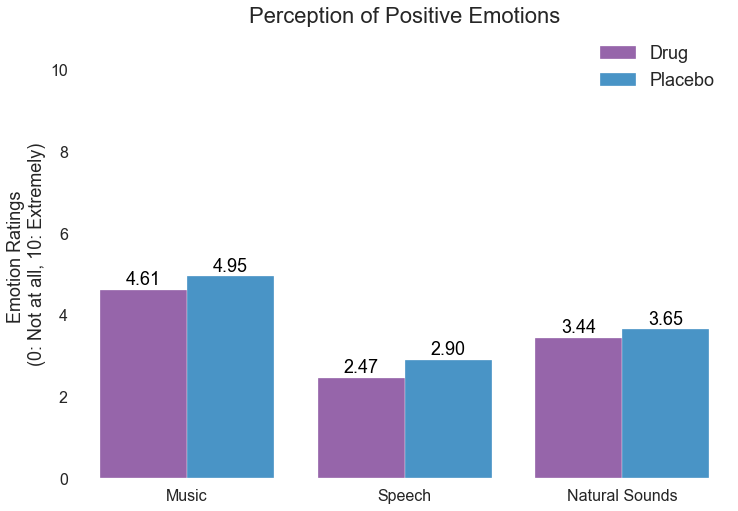

In [9]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Positive", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**The above graph shows that acetaminophen attenuated the perception of positive emotion similarly in music, natural sounds, and speech stimuli.**

#### *Graph Stimulus Type:* **Negative**
Now we can look at the attentuating effect of acetaminophen on perceived negative emotions.

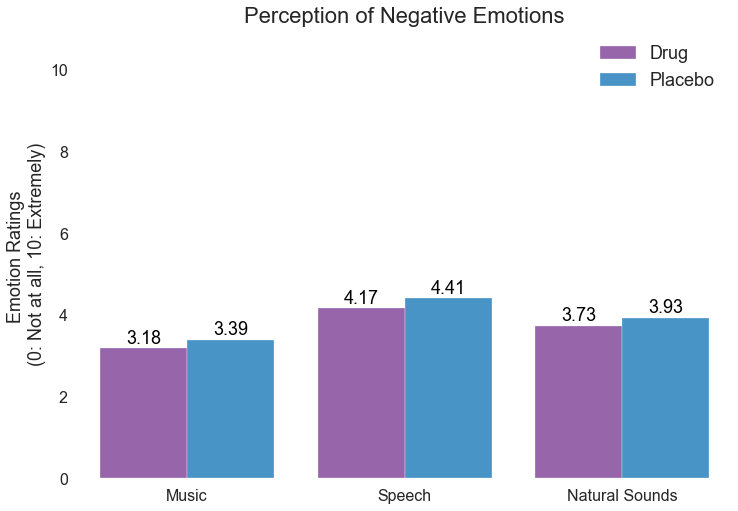

In [10]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Negative", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**The graph shows that acetaminophen also attenuated the perception of negative emotion similarly in music, natural sounds, and speech stimuli.**

**Comparing this graph to the graph above on positive emotions, we can see that the blunting effect of acetaminophen was similar across ratings of positive and negative emotions.**

#### *Graph Stimulus Type:* **Arousal**
Now we can look at the attentuating effect of acetaminophen on arousal ratings.

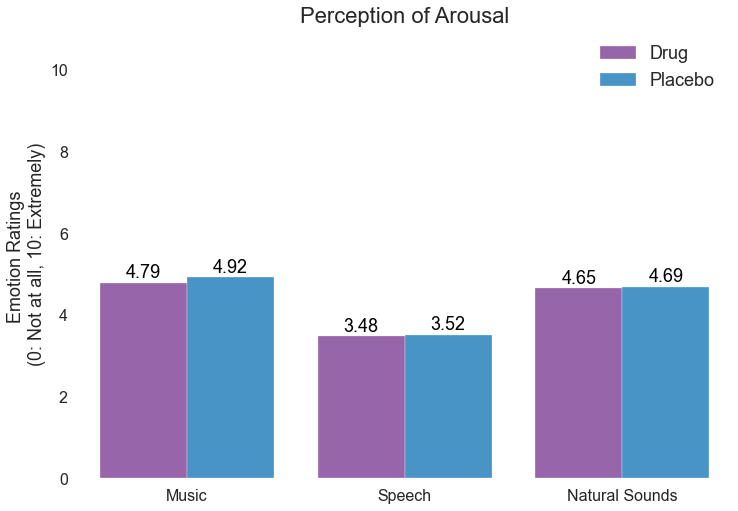

In [11]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Arousal", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**No real drug/placebo effect on arousal ratings.** 

# *Emotion Type (Positive, Negative, Neutral)*
Now we check whether acetaminophen blunts perceived emotion ratings for positive stimuli, negative stimuli, and netural stimuli.

In [12]:
# Positive Emotion Ratings
print("Perceived Emotion Emotion Type -- Positive")
print(perceivedLong.groupby(['DrugPlacebo', 'PosNeg'])['Positive'].mean().round(2), "\n")
        
# Negative Emotion Ratings
print("Perceived Emotion Emotion Type -- Negative")
print(perceivedLong.groupby(['DrugPlacebo', 'PosNeg'])['Negative'].mean().round(2), "\n")
        
# Arousal Ratings
print("Perceived Emotion Emotion Type -- Arousal")
print(perceivedLong.groupby(['DrugPlacebo', 'PosNeg'])['Arousal'].mean().round(2))

Perceived Emotion Emotion Type -- Positive
DrugPlacebo  PosNeg  
Drug         Negative    1.35
             Neutral     1.87
             Positive    6.36
Placebo      Negative    1.65
             Neutral     2.33
             Positive    6.72
Name: Positive, dtype: float64 

Perceived Emotion Emotion Type -- Negative
DrugPlacebo  PosNeg  
Drug         Negative    6.23
             Neutral     2.68
             Positive    1.40
Placebo      Negative    6.44
             Neutral     3.03
             Positive    1.55
Name: Negative, dtype: float64 

Perceived Emotion Emotion Type -- Arousal
DrugPlacebo  PosNeg  
Drug         Negative    4.40
             Neutral     1.72
             Positive    5.07
Placebo      Negative    4.39
             Neutral     1.76
             Positive    5.23
Name: Arousal, dtype: float64


## *Circumplex Type (Arousal and Valence Info)*
We can look to see whether the drug attenuation affects perceived emotion ratings for different types of emotional stimuli:
* Negative Valence, High Arousal
* Negative Valence, Low Arousal
* Neutral
* Positive Valence, Low Arousal
* Positive Valence, High Arousal


In [13]:
# Positive Emotion Ratings
print("Perceived Emotion Circumplex -- Positive")
print(perceivedLong.groupby(['DrugPlacebo', 'Russell'])['Positive'].mean().round(2), "\n")

# Negative Emotion Ratings
print("Perceived Emotion Circumplex -- Negative")    
print(perceivedLong.groupby(['DrugPlacebo', 'Russell'])['Negative'].mean().round(2), "\n")

# Arousal Ratings
print("Perceived Emotion Circumplex -- Arousal")        
print(perceivedLong.groupby(['DrugPlacebo', 'Russell'])['Arousal'].mean().round(2))

Perceived Emotion Circumplex -- Positive
DrugPlacebo  Russell                 
Drug         Neg-Valence High-Arousal    1.08
             Neg-Valence Low-Arousal     1.61
             Neutral                     1.87
             Pos-Valence High-Arousal    7.19
             Pos-Valence Low-Arousal     5.55
Placebo      Neg-Valence High-Arousal    1.34
             Neg-Valence Low-Arousal     1.97
             Neutral                     2.33
             Pos-Valence High-Arousal    7.55
             Pos-Valence Low-Arousal     5.90
Name: Positive, dtype: float64 

Perceived Emotion Circumplex -- Negative
DrugPlacebo  Russell                 
Drug         Neg-Valence High-Arousal    6.78
             Neg-Valence Low-Arousal     5.69
             Neutral                     2.68
             Pos-Valence High-Arousal    1.07
             Pos-Valence Low-Arousal     1.73
Placebo      Neg-Valence High-Arousal    6.93
             Neg-Valence Low-Arousal     5.94
             Neutral       

#### *Graph Circumplex:* **Positive**
Once again, a graph will help visualize this effect.

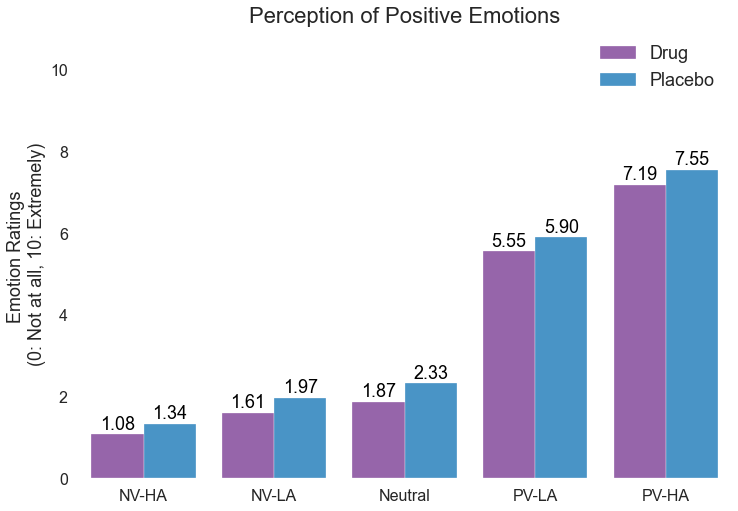

In [14]:
# change labels for easy interpretation
perceivedLong['Russell'].replace("Neg-Valence High-Arousal", "NV-HA", inplace=True)
perceivedLong['Russell'].replace("Pos-Valence High-Arousal", "PV-HA", inplace=True)
perceivedLong['Russell'].replace("Neg-Valence Low-Arousal", "NV-LA", inplace=True)
perceivedLong['Russell'].replace("Pos-Valence Low-Arousal", "PV-LA", inplace=True)

# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Positive", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**Acetaminophen attenuated the perception of positive emotion similarly in stimuli classified as *negative valence-high arousal*, *negative valence-low arousal*, *neutral*, *positive valence-low arousal*, and *positive valence-high arousal*.**

#### *Graph Circumplex:* **Negative**
And our last graph.

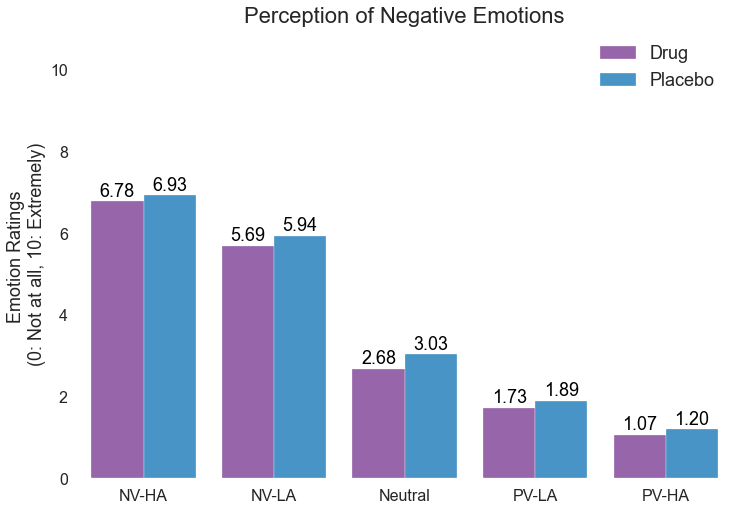

In [15]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Negative", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**The above graph shows, once again, that acetaminophen blunts the perception of negative emotion similarly in stimuli classified as *negative valence-high arousal*, *negative valence-low arousal*, *neutral*, *positive valence-low arousal*, and *positive valence-high arousal*.**

**Furthermore, the attenuating effect of acetaminophen was similar across ratings of positive and negative perceived emotions.**

#### *Graph Circumplex:* **Arousal**
Once again, a graph will help visualize this effect.

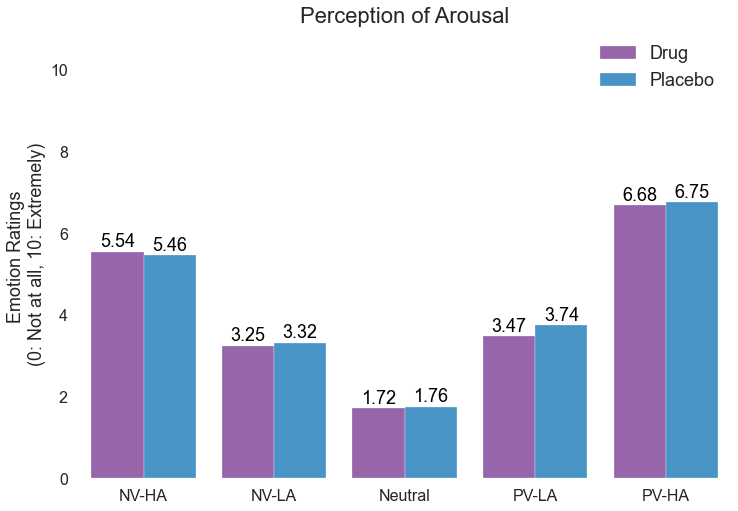

In [16]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Arousal", hue="DrugPlacebo", data=perceivedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

**No real drug/placebo effect on arousal ratings.** 

# **Plot perceived emotions by sound type**

In [17]:
music = perceivedLong[perceivedLong['SoundType'] == "Music"]
natural = perceivedLong[perceivedLong['SoundType'] == "Natural Sounds"]
speech = perceivedLong[perceivedLong['SoundType'] == "Speech"]

## *Music*

In [18]:
musicEmotions = [
    (music['Stimulus'].str.contains('Tender', regex=True) == True),
    (music['Stimulus'].str.contains('Sad', regex=True) == True),
    (music['Stimulus'].str.contains('Happy', regex=True) == True),
    (music['Stimulus'].str.contains('Fear', regex=True) == True)]
choices = ['Tender', 'Sad', 'Happy', 'Fear']
music['Stimulus'] = np.select(musicEmotions, choices)

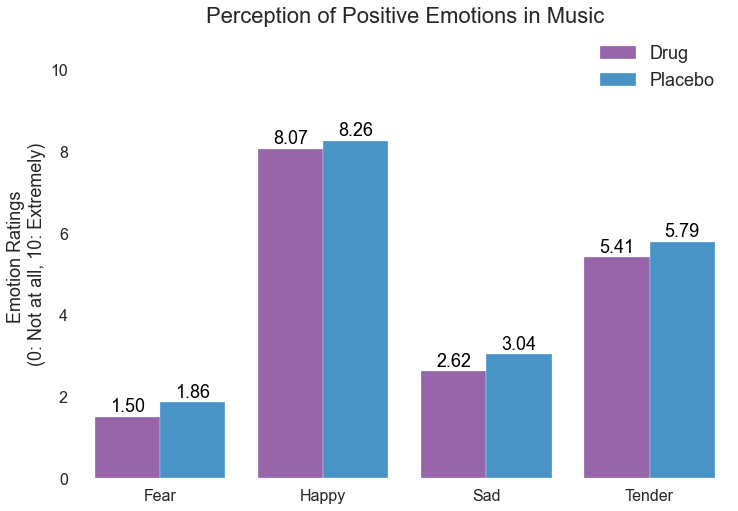

In [19]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

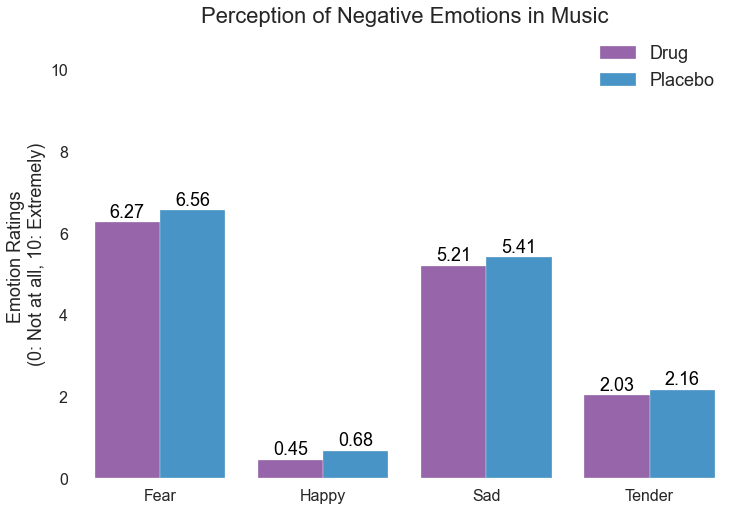

In [20]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

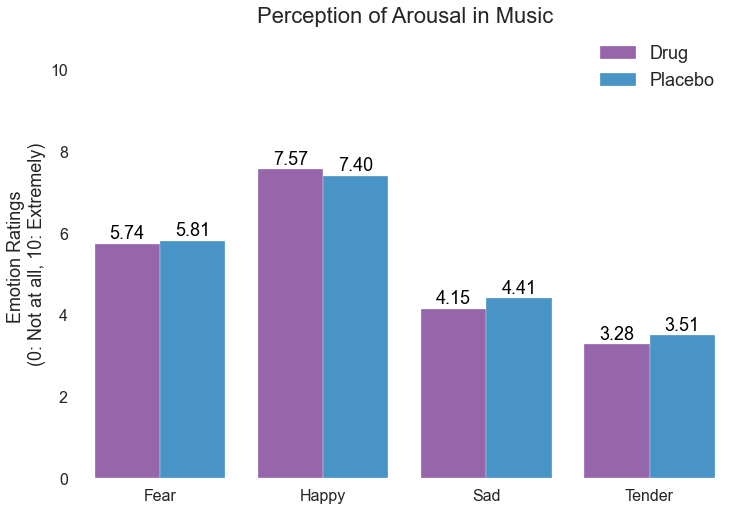

In [21]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Arousal", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Speech*

In [22]:
speechEmotions = [
    (speech['Stimulus'].str.contains('Neutral', regex=True) == True),
    (speech['Stimulus'].str.contains('Sad', regex=True) == True),
    (speech['Stimulus'].str.contains('Happy', regex=True) == True),
    (speech['Stimulus'].str.contains('Fear', regex=True) == True)]
choices = ['Neutral', 'Sad', 'Happy', 'Fear']
speech['Stimulus'] = np.select(speechEmotions, choices)

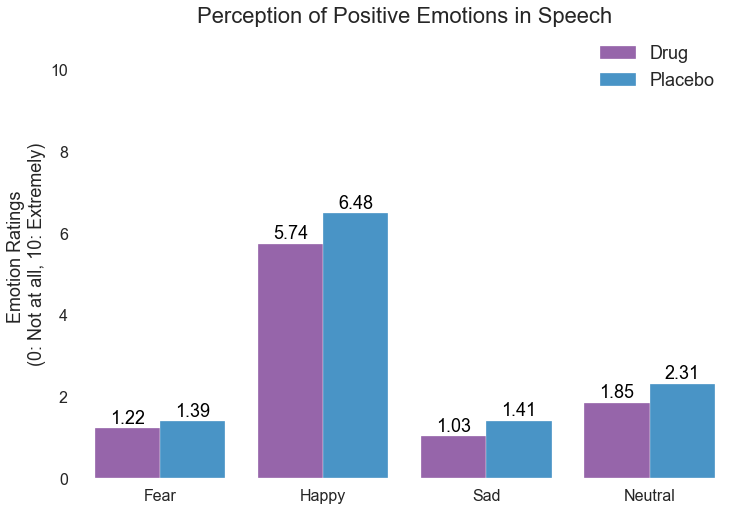

In [23]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=speech, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Speech', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

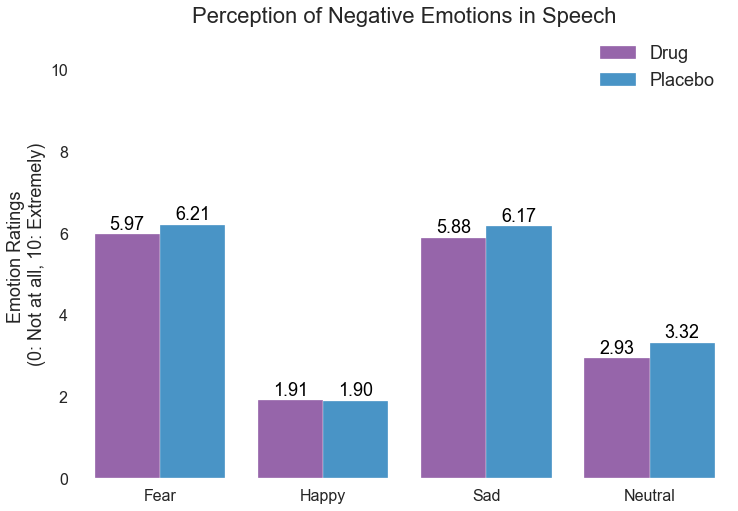

In [24]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=speech, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Speech', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

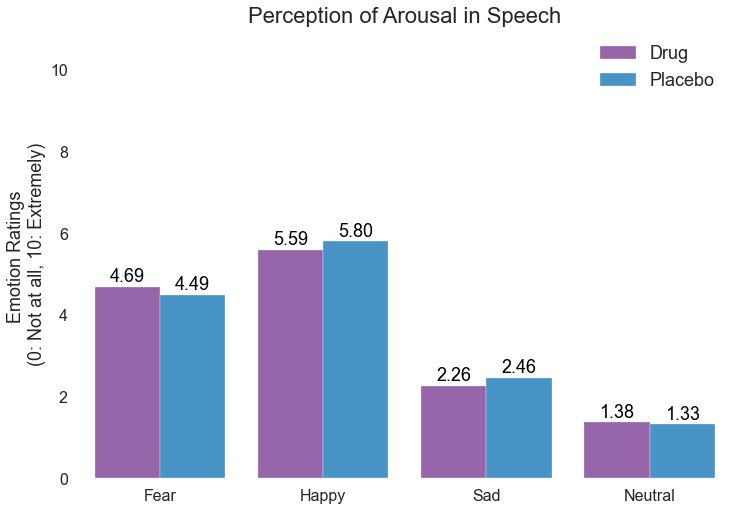

In [25]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Arousal", hue="DrugPlacebo", data=speech, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Speech', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Human*

In [26]:
human = natural[natural['Stimulus'].isin(['Neutral Human', 
                                             'Negative-Valence High-Arousal Human', 
                                             'Negative-Valence Low-Arousal Human', 
                                             'Positive-Valence High-Arousal Human', 
                                             'Positive-Valence Low-Arousal Human'])]

human['Stimulus'].replace("Neutral Human", "Neutral", inplace=True)
human['Stimulus'].replace("Negative-Valence High-Arousal Human", "NV-HA", inplace=True)
human['Stimulus'].replace("Negative-Valence Low-Arousal Human", "NV-LA", inplace=True)
human['Stimulus'].replace("Positive-Valence High-Arousal Human", "PV-HA", inplace=True)
human['Stimulus'].replace("Positive-Valence Low-Arousal Human", "PV-LA", inplace=True)

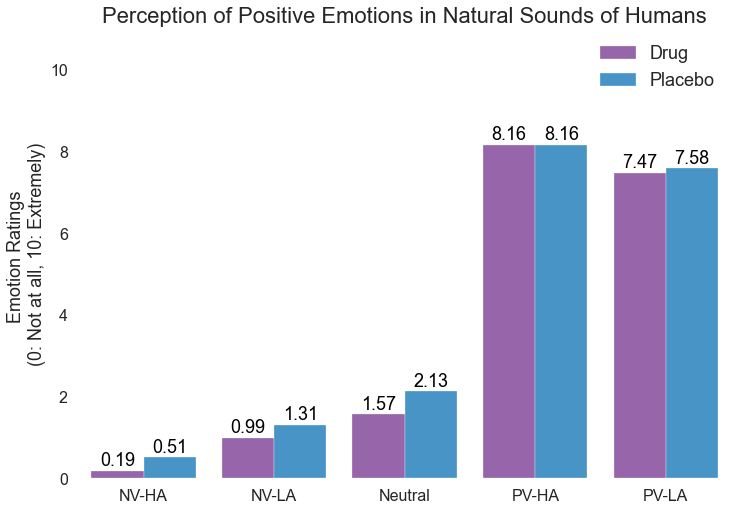

In [27]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

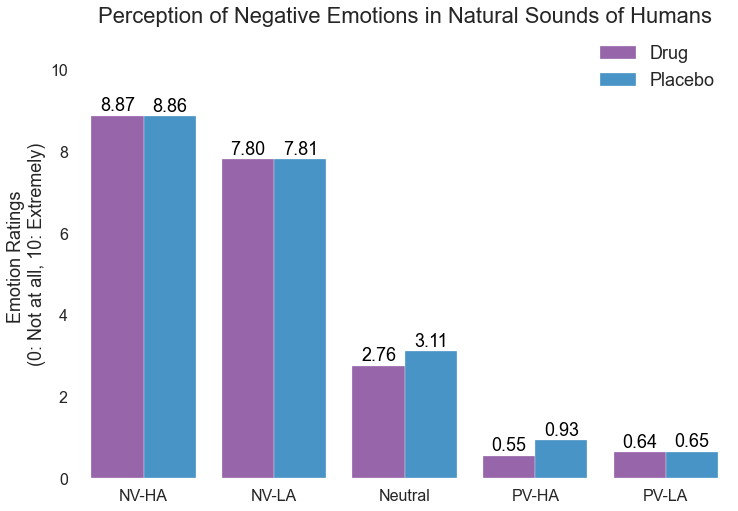

In [28]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

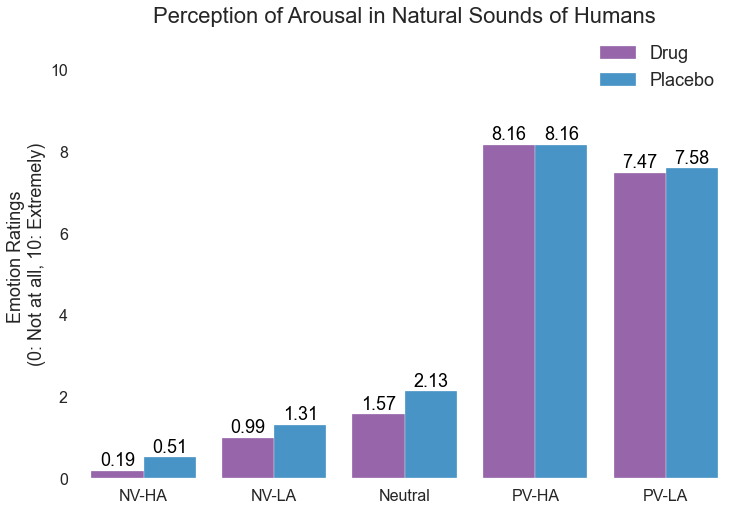

In [29]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Non-Human*

In [30]:
nonhuman = natural[natural['Stimulus'].isin(['Neutral Non-human', 
                                             'Negative-Valence High-Arousal Non-human', 
                                             'Negative-Valence Low-Arousal Non-human', 
                                             'Positive-Valence High-Arousal Non-human', 
                                             'Positive-Valence Low-Arousal Non-human'])]

nonhuman['Stimulus'].replace("Neutral Non-human", "Neutral", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence High-Arousal Non-human", "NV-HA", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence Low-Arousal Non-human", "NV-LA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence High-Arousal Non-human", "PV-HA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence Low-Arousal Non-human", "PV-LA", inplace=True)

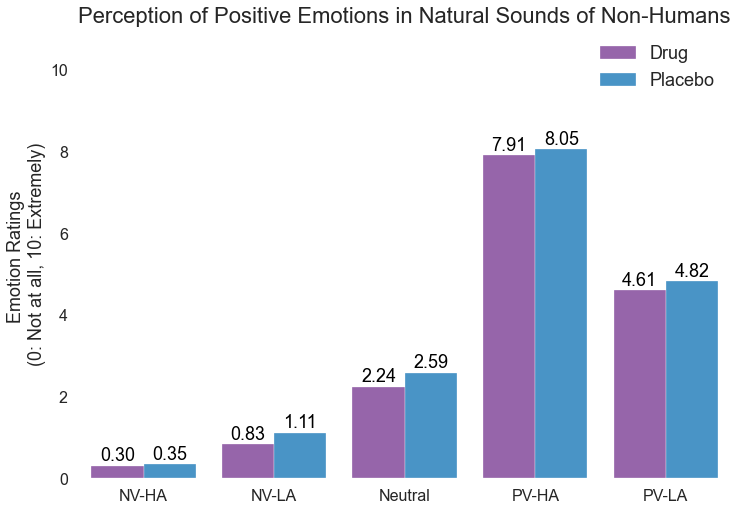

In [31]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Positive Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

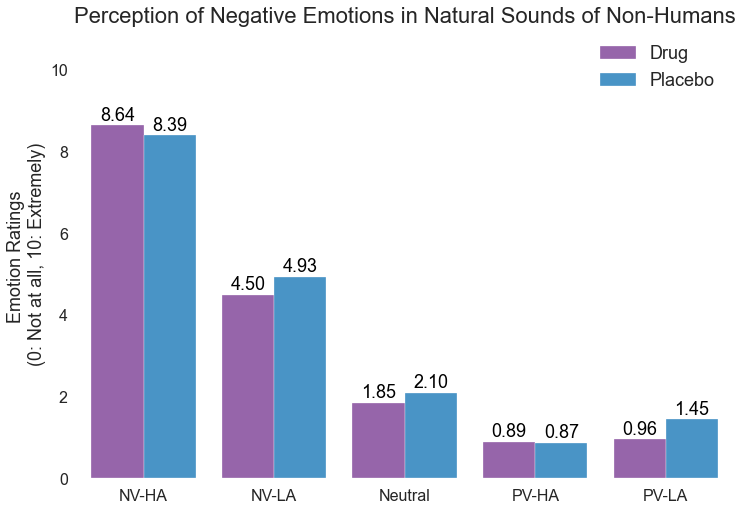

In [32]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Negative Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

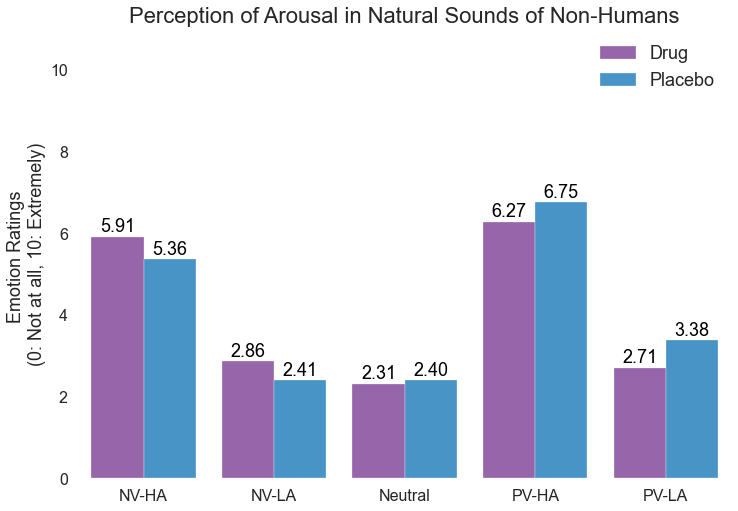

In [33]:
# dimensions
colors = ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Arousal", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Perception of Arousal in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

# Summary
We will make some small changes with the dataframe for future use and summarize the findings with a pandas profile.


In [34]:
# change columns back
perceivedLong['DrugPlacebo'].replace("Placebo", 0, inplace=True)
perceivedLong['DrugPlacebo'].replace("Drug", 1, inplace=True)
perceivedLong['Russell'].replace("NV-HA", "Neg-Valence High-Arousal", inplace=True)
perceivedLong['Russell'].replace("PV-HA", "Pos-Valence High-Arousal", inplace=True)
perceivedLong['Russell'].replace("NV-LA", "Neg-Valence Low-Arousal", inplace=True)
perceivedLong['Russell'].replace("PV-LA", "Pos-Valence Low-Arousal", inplace=True)

# pandas_profiling.ProfileReport(perceivedLong)
perceivedLong.head(2)

,FixedID,DrugCode,DrugPlacebo,Locus,Stimulus,Positive,Negative,Arousal,Familiarity,Anger,Anxious,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Joyful,Nostalgic,Peaceful,Power,Relaxed,Sad,Softhearted,Surprised,Sympathetic,Tender,Transcendent,Tension,Wonder,Neutral,PosNeg,SoundType,Russell
8,8.0,8J,1,Perceived,Fear Music 1,NaN,NaN,NaN,NaN,0,Not Measured,0,0,0,0,0,0,0,Not Measured,Not Measured,Not Measured,Not Measured,0,0,Not Measured,0,Not Measured,0,Not Measured,Not Measured,Not Measured,0,Negative,Music,Neg-Valence High-Arousal
9,4.0,4J,1,Perceived,Fear Music 1,3.0,6.0,9.0,0.0,0,Not Measured,0,0,2,2,0,0,1,Not Measured,Not Measured,Not Measured,Not Measured,0,0,Not Measured,0,Not Measured,0,Not Measured,Not Measured,Not Measured,0,Negative,Music,Neg-Valence High-Arousal


# Write out csv.

In [35]:
perceivedLong.to_csv('perceivedLong.csv', index=False)